In [ ]:
 !pip install xmltodict

In [ ]:
import os
import keras
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import xmltodict
import numpy as np

#Convert xml to json

In [ ]:
def xml_to_json(xml_file):
    with open(xml_file, 'r') as f:
        xml_content = f.read()
        json_data = xmltodict.parse(xml_content)
    return json_data

def main():
    # Directory containing XML files
    xml_dir = "/content/NEU-DET/train/annotations"
    # Directory to save JSON files
    json_dir = "/content/NEU-DET/train/Json_Annotations"

    # Iterate through each XML file in the directory
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            # Get the full path of the XML file
            xml_path = os.path.join(xml_dir, xml_file)
            # Convert XML to JSON
            json_data = xml_to_json(xml_path)
            # Construct the path for the JSON file
            json_file = os.path.splitext(xml_file)[0] + ".json"
            json_path = os.path.join(json_dir, json_file)
            # Write JSON data to file
            with open(json_path, 'w') as f:
                json.dump(json_data, f, indent=4)  # Write JSON with indentation for readability

if __name__ == "__main__":
    main()

#Generating and Validating tf records

In [ ]:
with open("/content/NEU-DET/train/Json_Annotations/crazing_21.json", "r") as f:
    annotations = json.load(f)["annotation"]

print(f"Number of images: {len(annotations)}")

pprint.pprint(annotations['object'])

Number of images: 6
[{'bndbox': {'xmax': '198', 'xmin': '27', 'ymax': '76', 'ymin': '27'},
  'difficult': '0',
  'name': 'crazing',
  'pose': 'Unspecified',
  'truncated': '0'},
 {'bndbox': {'xmax': '197', 'xmin': '20', 'ymax': '120', 'ymin': '85'},
  'difficult': '0',
  'name': 'crazing',
  'pose': 'Unspecified',
  'truncated': '0'},
 {'bndbox': {'xmax': '198', 'xmin': '24', 'ymax': '187', 'ymin': '123'},
  'difficult': '0',
  'name': 'crazing',
  'pose': 'Unspecified',
  'truncated': '0'}]


In [ ]:
for obj in annotations["object"]:
        print(obj['bndbox'])

{'xmin': '27', 'ymin': '27', 'xmax': '198', 'ymax': '76'}
{'xmin': '20', 'ymin': '85', 'xmax': '197', 'ymax': '120'}
{'xmin': '24', 'ymin': '123', 'xmax': '198', 'ymax': '187'}


In [ ]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example["image/encodedrawdata"])
    example["image/encodedrawdata"] = image
    return example


In [ ]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string."""
    if isinstance(value, str):
        value = value.encode('utf-8')  # Convert string to bytes
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))



def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    if isinstance(value, list):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    else:
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def bytes_list_feature(value):
    """Returns a bytes_list from a string."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v.encode() for v in value]))

def int64_list_feature(value):
    """Returns an int64_list from a list of int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


# Define the feature description

feature_description = {
    "image/width": tf.io.FixedLenFeature([], tf.int64),
    "image/height": tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
    'image/object/bndbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bndbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bndbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bndbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    'image/object/truncated': tf.io.VarLenFeature(tf.int64),
}

def create_tf_example(image, annotation):
    # Extract image filename and size
    filename = annotation['annotation']['filename']
    width = int(annotation['annotation']['size']['width'])
    height = int(annotation['annotation']['size']['height'])
    source_id = filename  # Assuming filename is the source ID
    encodedrawdata = tf.io.encode_jpeg(image).numpy()  # Encoded raw image data

    # Initialize lists to store object features
    xmin_list = []
    xmax_list = []
    ymin_list = []
    ymax_list = []
    class_text_list = []
    difficult_list = []
    truncated_list = []

    for obj in annotation['annotation']['object']:
    # Check if obj is a dictionary
      if isinstance(obj, dict):
        # Extract bounding box coordinates
        bndbox = obj['bndbox']
        xmin = float(bndbox['xmin'])
        xmax = float(bndbox['xmax'])
        ymin = float(bndbox['ymin'])
        ymax = float(bndbox['ymax'])

        # Append object features to lists
        xmin_list.append(xmin)
        xmax_list.append(xmax)
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        class_text_list.append(obj['name'])
        difficult_list.append(int(obj['difficult']))
        truncated_list.append(int(obj['truncated']))
    # If obj is a list
      elif isinstance(obj, list):
        # Iterate over each item in the list
          for item in obj:
            # Extract bounding box coordinates
            bndbox = item['bndbox']
            xmin = float(bndbox['xmin'])
            xmax = float(bndbox['xmax'])
            ymin = float(bndbox['ymin'])
            ymax = float(bndbox['ymax'])

            # Append object features to lists
            xmin_list.append(xmin)
            xmax_list.append(xmax)
            ymin_list.append(ymin)
            ymax_list.append(ymax)
            class_text_list.append(item['name'])
            difficult_list.append(int(item['difficult']))
            truncated_list.append(int(item['truncated']))

    # Construct the TFRecord feature dictionary
    feature = {
        'image/width': int64_feature(width),
        'image/height': int64_feature(height),
        'image/filename': bytes_feature(filename),
        'image/encodedrawdata': bytes_feature(encodedrawdata),
        'image/object/bndbox/xmin': float_feature_list(xmin_list),
        'image/object/bndbox/xmax': float_feature_list(xmax_list),
        'image/object/bndbox/ymin': float_feature_list(ymin_list),
        'image/object/bndbox/ymax': float_feature_list(ymax_list),
        'image/object/class/text': bytes_list_feature(class_text_list),
        'image/object/difficult': int64_list_feature(difficult_list),
        'image/object/truncated': int64_list_feature(truncated_list),
    }

    # Create a TFRecord example
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

# Directory containing JSON annotation files
json_dir = "/content/NEU-DET/train/Json_Annotations"

# Output directory for TFRecord files
tfrecord_dir = "/content/NEU-DET/train/Train_tfrecords_dir"

# Iterate through each JSON annotation file
for json_file in os.listdir(json_dir):
    if json_file.endswith(".json"):
        # Read JSON annotation file
        with open(os.path.join(json_dir, json_file), "r") as f:
            annotation = json.load(f)

        # Load image and preprocess if necessary
        image_dir = "/content/Train_Images/images"
        image_filename = os.path.splitext(annotation['annotation']['filename'])[0] + ".jpg"
        image_path = os.path.join(image_dir, image_filename)
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))

        # Create TFRecord example
        tfrecord_example = create_tf_example(image, annotation)

        # Write TFRecord to file
        tfrecord_path = os.path.join(tfrecord_dir, os.path.splitext(json_file)[0] + ".tfrecord")
        with tf.io.TFRecordWriter(tfrecord_path) as writer:
            writer.write(tfrecord_example)
        print(f"Successfully created TFRecord: {tfrecord_path}")

#Validating data in the tf record

image/object/bbox/xmax: SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=float32), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64))
image/object/bbox/xmin: SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=float32), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64))
image/object/bbox/ymax: SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=float32), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64))
image/object/bbox/ymin: SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=float32), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64))
image/object/class/text: SparseTensor(indices=tf.Tensor([], shape=(0, 1), dtype=int64), values=tf.Tensor([], shape=(0,), dtype=string), dense_shape=tf.Tensor([0], shape=(1,), dtype=int64))
image/object/difficult: SparseTensor(indices=tf.Tensor(

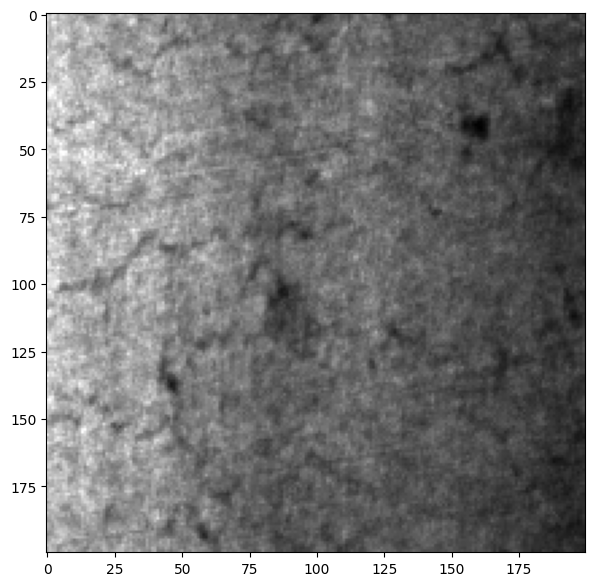

In [ ]:
raw_dataset = tf.data.TFRecordDataset("/content/NEU-DET/train/Train_tfrecords_dir/crazing_45.tfrecord")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image/encodedrawdata'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image/encodedrawdata"].numpy())
    plt.show()

#Model Creation

In [ ]:
import os
import tensorflow as tf

# Define function to parse TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to floats in [0, 1]
    label = example['image/object/class/text']
    return image, label

# Define function to load TFRecord dataset
def load_dataset(file_pattern, batch_size):
    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.interleave(tf.data.TFRecordDataset, cycle_length=4)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_tfrecord_files = "/content/NEU-DET/train/Train_tfrecords_dir/*.tfrecord"

image_height = 200
image_width = 200
n_color_channels = 3
n_classes = 6
batch_size = 16

num_train_files = len(tf.io.gfile.glob(train_tfrecord_files))
steps_per_epoch = num_train_files // batch_size

# Define model architecture
base_model = tf.keras.applications.Xception(input_shape=(image_height, image_width, n_color_channels),
                                            include_top=False,
                                            weights="imagenet")

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(n_classes, activation='relu')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Load training and testing datasets
batch_size = 32
train_dataset = load_dataset(train_tfrecord_files, batch_size)

# Train the model
model.fit(train_dataset,
          epochs=10,
          steps_per_epoch=steps_per_epoch)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node Cast_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-25-fedd9907a1fa>", line 66, in <cell line: 66>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 708, in update_state

Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_107446]